In [1]:
import cobra
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
#import numpy as np
import pandas as pd
import seaborn as sns
import os
from cameo import fba
import cmasher as cmr

In [2]:
cobra_config = cobra.Configuration()
cobra_config.solver = "cplex"

In [3]:
with open("../sbmls/b971180d_Adams2001_Malt-S0.sbml", "r") as f:
    malt = cobra.io.read_sbml_model(f)
with open("../sbmls/b971180d_Adams2001_MaltPep-S0.sbml", "r") as f:
    maltpep = cobra.io.read_sbml_model(f)
with open("../sbmls/b971180d_Adams2001_Pep-S0.sbml", "r") as f:
    pep = cobra.io.read_sbml_model(f)

'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.


## Universal constraints
1. GAPDH is removed in glycolytic conditions
2. GAPOR is removed in gluconeogenic conditions

Note: In the Maltose + Peptide, we did not apply the glycolytic or gluconeogenic constraints, since both directions are possible

In [4]:
for model in [malt]:
    model.reactions.R01061.upper_bound = 0
    model.reactions.R01063.upper_bound = 0
for model in [pep]:
    model.reactions.R07159.upper_bound = 0

#### Comparison with experimental data
From Adams et al. 2001, table 1. The values are doubling times (min).
The model simulates growth yields, not rates, so we did a qualitative comparison of growth/non-growth

The model was considered to not grow if its optimum biomass yield was less than 0.05 g CDW.

In [5]:
# Experimental data from Adams et al
exp = pd.read_table("./data/Adams2001_growth.tsv")

In [6]:
exp

,Sulfur,media,Doubling time,stdev
0,Present,Maltose,65.1,1.6
1,Absent,Maltose,63.3,0.8
2,Present,Peptides,40.5,4.8
3,Absent,Peptides,0.0,0.0
4,Present,Peptides + maltose,47.6,1.4
5,Absent,Peptides + maltose,64.1,5.8


In [7]:
sim = []
for name, model in {"Maltose": malt,
              "Peptides": pep,
              "Peptides + maltose": maltpep}.items():
    tmp = model.copy()
    sim.append(["Present", name, fba(tmp).objective_value])
    # Remove sulfur
    tmp.reactions.EX_C00087_LSQBKT_e_RSQBKT_.lower_bound = 0
    sim.append(["Absent", name, fba(tmp).objective_value])
result = pd.DataFrame(sim, columns=["Sulfur", "media", "growth"]).set_index(["Sulfur", "media"])

df = exp.join(result, on=["Sulfur", "media"])
df["exp"] = df["Doubling time"] > 0.05
df["sim"] = df["growth"] > 0.05
df = df.drop(columns=["Doubling time", "stdev", "growth"]).set_index(["Sulfur", "media"])

labels = df.copy()
labels["exp"] = ["+" if x else "-" for x in df["exp"]]
labels["sim"] = ["+" if x else "-" for x in df["sim"]]

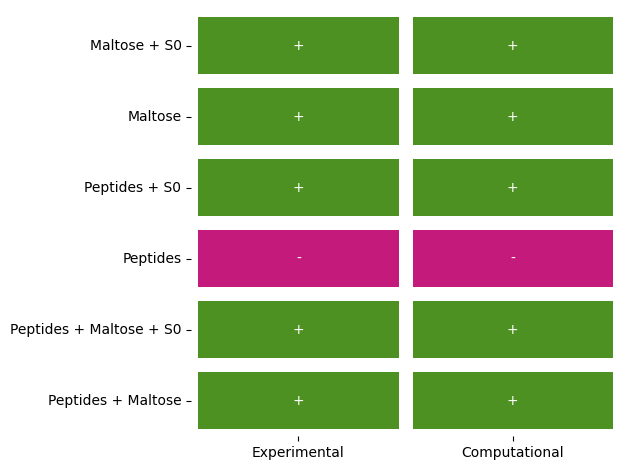

In [8]:
cmap = cmr.get_sub_cmap("PiYG", 0.1, 0.9)
ax = sns.heatmap(df, linewidths=10,
            cmap=cmap,#sns.color_palette("PiYG", as_cmap=True),
            annot=labels,
            fmt="",
            cbar=False)
ax.set_xticklabels(["Experimental", "Computational"])
ax.set_yticklabels(["Maltose + S0", "Maltose", "Peptides + S0", "Peptides", "Peptides + Maltose + S0", "Peptides + Maltose"])
ax.set_ylabel("")
plt.tight_layout()
plt.savefig("./figures/FigS2.tiff",
            dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})